# Laboratorium

### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js
from functools import cmp_to_key as compare
from functools import reduce
from math import sqrt
import os

TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
               
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
          
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points


class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)


class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()

___

# Rozwiązanie

## Zbiór punktów nr 1

<IPython.core.display.Javascript object>


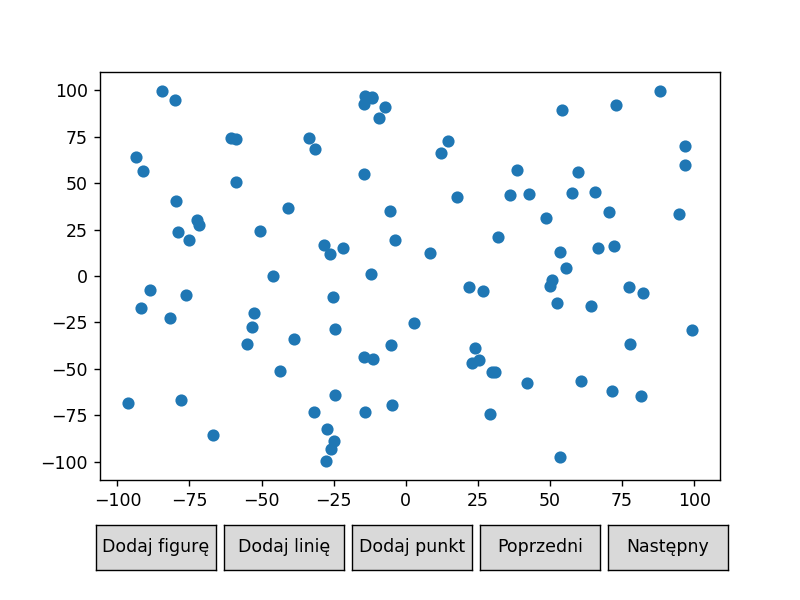

In [3]:
%matplotlib notebook

def generate_set_1(n, rang):
    x = np.random.uniform(rang[0], rang[1], n)
    y = np.random.uniform(rang[0], rang[1], n)

    return np.dstack((x, y))[0]


data_set_1 = generate_set_1(100, (-100, 100))
plot = Plot(points=[PointsCollection(data_set_1)])
plot.draw()

## Zbiór punktów nr 2

<IPython.core.display.Javascript object>


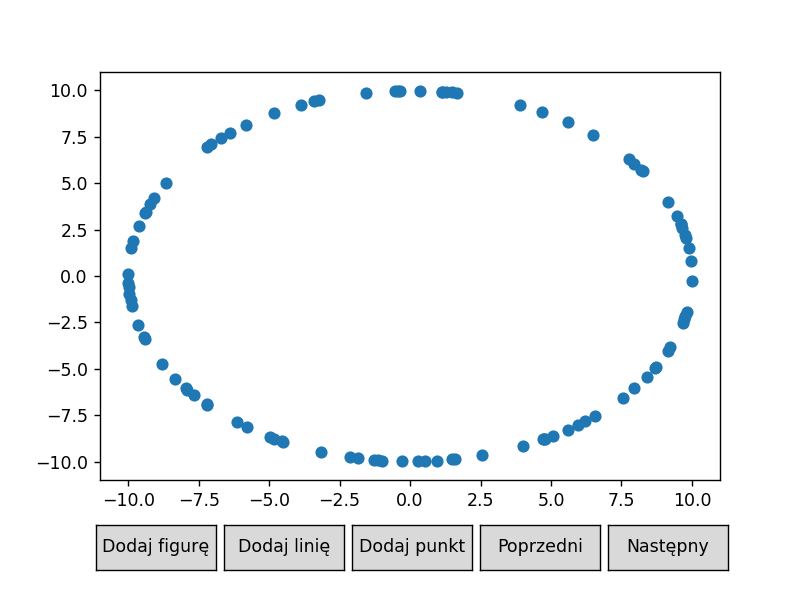

In [4]:
def generate_set_2(n, cent_pt, r):
    t = np.random.uniform(0, 2*np.pi, n)
    x = r*np.cos(t) + cent_pt[0]
    y = r*np.sin(t) + cent_pt[1]
    
    return np.dstack((x, y))[0]
    

data_set_2 = generate_set_2(100, (0, 0), 10)
plot = Plot(points=[PointsCollection(data_set_2)])
plot.draw()

## Zbiór punktów nr 3

<IPython.core.display.Javascript object>


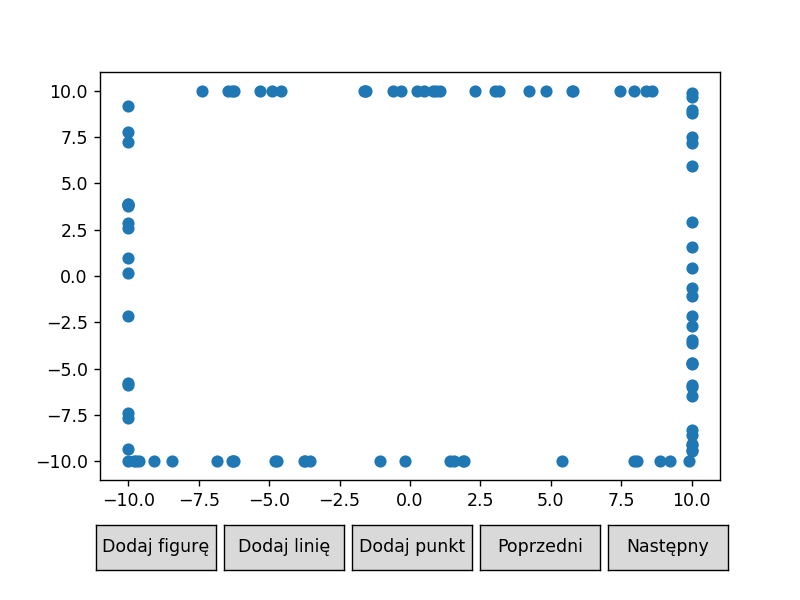

In [5]:
def generate_set_3(n, vertices):
    vertices.sort(key=lambda tup: (tup[0], tup[1]))
    
    rect_sides = [lambda x: (vertices[0][0], x*(vertices[1][1]-vertices[0][1])+vertices[0][1]),
                  lambda x: (x*(vertices[2][0]-vertices[1][0])+vertices[1][0], vertices[1][1]),
                  lambda x: (vertices[2][0], x*(vertices[2][1]-vertices[3][1])+vertices[3][1]),
                  lambda x: (x*(vertices[3][0]-vertices[0][0])+vertices[0][0], vertices[0][1])]
    
    t = np.random.uniform(0, 1, n)
    
    return np.array(list(map(lambda x: rect_sides[np.random.randint(4)](x), t)))


data_set_3 = generate_set_3(100, [(-10, 10), (-10, -10), (10, -10), (10, 10)])
plot = Plot(points=[PointsCollection(data_set_3)])
plot.draw()

## Zbiór punktów nr 4

<IPython.core.display.Javascript object>


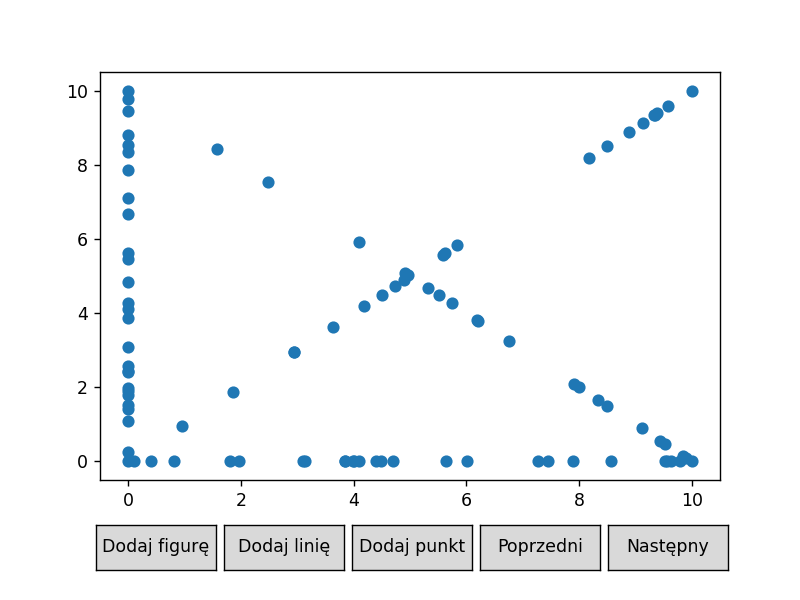

In [6]:
def generate_set_4(n_axis, n_diag, vertices):
    sides = [lambda x: (vertices[0][0], x*(vertices[1][1]-vertices[0][1])+vertices[0][1]),
             lambda x: (x*(vertices[2][0]-vertices[0][0])+vertices[0][0], vertices[0][1]),
             lambda x: (x*(vertices[3][0]-vertices[0][0])-vertices[0][0], x*(vertices[3][1]-vertices[0][1])-vertices[0][1]),
             lambda x: (x*(vertices[2][0]-vertices[1][0])+vertices[1][0], x*(vertices[2][1]-vertices[1][1])+vertices[1][1])]
    
    result_set = []
    for i in range(4):
        if i < 2:
            t = np.random.uniform(0, 1, n_axis)
        else:
            t = np.random.uniform(0, 1, n_diag)
            
        result_set.extend(list(map(lambda x: sides[i](x), t)))
        
    result_set.extend(vertices)
    
    return np.array(result_set)


data_set_4 = generate_set_4(25, 20, [(0, 0), (0, 10), (10, 0), (10, 10)])
plot = Plot(points=[PointsCollection(data_set_4)])
plot.draw()

# Implementacja funkcji

### Wyznacznik

In [7]:
def det_3x3(pt_a, pt_b, pt_c):
    return (pt_a[0]*pt_b[1] + pt_b[0]*pt_c[1] + pt_c[0]*pt_a[1]
           - pt_c[0]*pt_b[1] - pt_a[0]*pt_c[1] - pt_b[0]*pt_a[1])

### Obsługa nakładania się punktów do klasyfikacji względem kąta

In [8]:
def handle_overlapping(pt_a, pt_b, pt_c):
    if pt_a == pt_b:
        return -1
    if pt_a == pt_c:
        return 1

In [9]:
def angle_orientation(pt_a, pt_b, pt_c, tolerance=10e-12):
    det_val = det_3x3(pt_a, pt_b, pt_c)
    
    if det_val > tolerance:
        return -1
    elif det_val < -tolerance:
        return 1
    else:
        return 0

### Klasyfikacja punktów względem kąta

In [10]:
def angle_classification(pt_a, pt_b, pt_c, tolerance):
    result_ovrl = handle_overlapping(pt_a, pt_b, pt_c)
    
    if result_ovrl in (-1, 1):
        return result_ovrl
    
    return angle_orientation(pt_a, pt_b, pt_c, tolerance)

### Usunięcie punktów współliniowych

In [11]:
def remove_collinear(data_set, min_pt, tolerance):
    idx = 1
    removed = []
    
    while idx < len(data_set)-1:
        det_val = det_3x3(min_pt, data_set[idx], data_set[idx+1])
        
        if abs(det_val) < tolerance:
            if dist(data_set[idx], min_pt) < dist(data_set[idx+1], min_pt):
                removed.append(data_set[idx])
                data_set.pop(idx)
            else:
                removed.append(data_set[idx+1])
                data_set.pop(idx+1)
        else:
            idx += 1
            
    return data_set, removed

### Obsługa wizualizacji kroków algorytmu Grahama

In [12]:
def generate_scene(data_set, stack, idx, removed_data=[], last_scene=False, data_color="blue", 
                   stack_color="magenta", last_pt_color="gold", removed_color="black"):
    
    stack_lines = [(stack[i], stack[i+1]) for i in range(len(stack)-1)]
    last_line = [(data_set[idx], stack[-1])]
    
    if last_scene:
        stack_lines.append([stack[-1], stack[0]])
        return Scene([PointsCollection(data_set), 
                      PointsCollection(stack, color=stack_color),
                      PointsCollection(removed_data, color=removed_color)], 
                     [LinesCollection(stack_lines, color=stack_color)])
        
    return Scene([PointsCollection(data_set),  
                  PointsCollection([data_set[idx]], color=last_pt_color),
                  PointsCollection(stack.copy(), color=stack_color)],
                 [LinesCollection(last_line, color=last_pt_color),
                  LinesCollection(stack_lines, color=stack_color)])

### Zapis punktów otoczki

In [13]:
def save_file(file_content, filename, mode="w"):
    results_directory = os.path.join(os.getcwd(), r"results")
    
    if not os.path.exists(results_directory):
        os.makedirs(results_directory)
    with open(os.path.join(results_directory, filename), mode) as file:
        for pt in file_content:
            file.write(f"{pt},\n")

# Algorytm Grahama

In [14]:
def graham_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_graham.txt"):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    sorted_data = sorted(data_set, key=compare(lambda x, y: angle_classification(min_pt, x, y, tolerance)))
    sorted_data, removed_data = remove_collinear(sorted_data, min_pt, tolerance)
    
    scenes, stack = [], []
    stack.extend(sorted_data[:3])
    idx = len(stack)
    
    while idx < len(sorted_data):
        new_scene = generate_scene(sorted_data, stack, idx)
        scenes.append(new_scene)
        
        pt_a, pt_b = stack[-2], stack[-1]
        pt_next = sorted_data[idx]
        
        if angle_orientation(pt_a, pt_b, pt_next) == -1:
            stack.append(pt_next)
            idx += 1
        else:
            stack.pop()
    
    if angle_orientation(pt_a, pt_b, min_pt) == 0:
        stack.pop()
        
    last_scene = generate_scene(sorted_data, stack, idx-1, removed_data=removed_data, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(stack, filename=filename)
        
    return scenes

## Algorytm Grahama dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


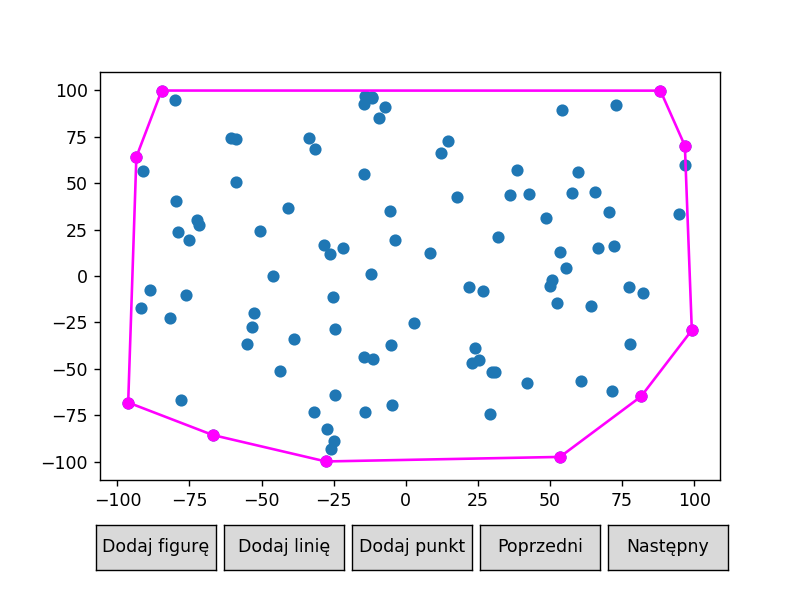

In [15]:
convex_hull_1 = graham_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_graham.txt")
plot = Plot(scenes=convex_hull_1)
plot.draw()

## Algorytm Grahama dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


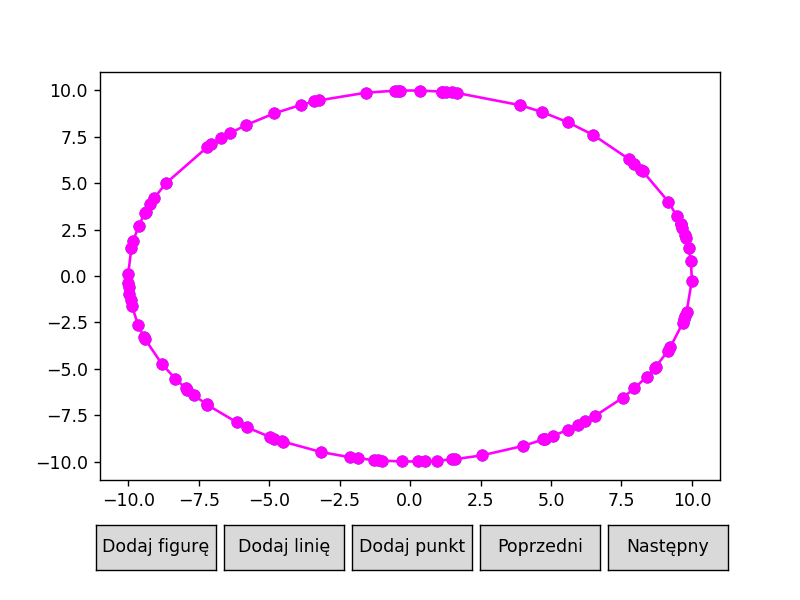

In [16]:
convex_hull_2 = graham_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_graham.txt")
plot = Plot(scenes=convex_hull_2)
plot.draw()

## Algorytm Grahama dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


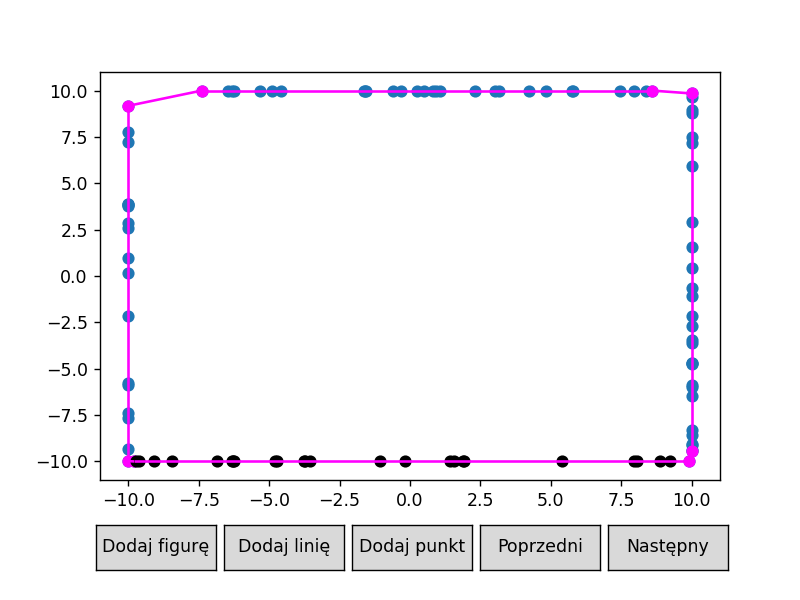

In [17]:
convex_hull_3 = graham_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_graham.txt")
plot = Plot(scenes=convex_hull_3)
plot.draw()

## Algorytm Grahama dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


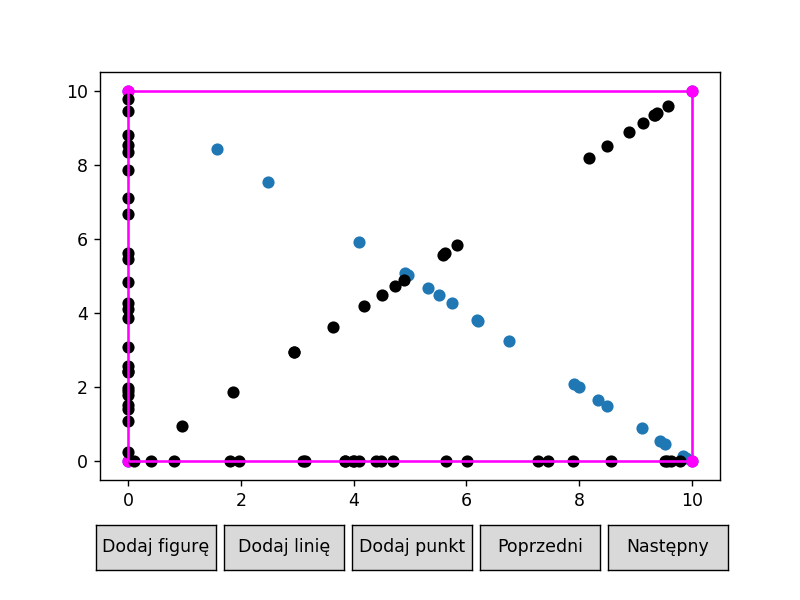

In [18]:
convex_hull_4 = graham_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_graham.txt")
plot = Plot(scenes=convex_hull_4)
plot.draw()

# Algorytm Jarvisa

In [19]:
def min_angle(pt_stack, pt_last, pt_next, tolerance=10e-12):
    if pt_stack == pt_last:
        return pt_next
    elif angle_orientation(pt_stack, pt_last, pt_next) == 1:
        return pt_next
    elif (angle_orientation(pt_stack, pt_last, pt_next) == 0 
        and dist(pt_stack, pt_next) > dist(pt_stack, pt_last)):
        return pt_next
    else:
        return pt_last

In [20]:
def jarvis_algorithm(data_set, tolerance=10e-12, save_results=False, filename="convex_hull_jarvis.txt"):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    scenes, stack = [], []
    pt_stack = min_pt
    
    while True:
        stack.append(pt_stack)
        pt_last = data_set[0]
        
        for idx in range(len(data_set)):
            new_scene = generate_scene(data_set, stack, idx)
            scenes.append(new_scene)
            pt_last = min_angle(pt_stack, pt_last, data_set[idx])
        
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    last_scene = generate_scene(data_set, stack, idx-1, last_scene=True)
    scenes.insert(0, last_scene)
    
    if save_results:
        save_file(stack, filename=filename)
    
    return scenes

## Algorytm Jarvisa dla zbioru punktów nr 1

<IPython.core.display.Javascript object>


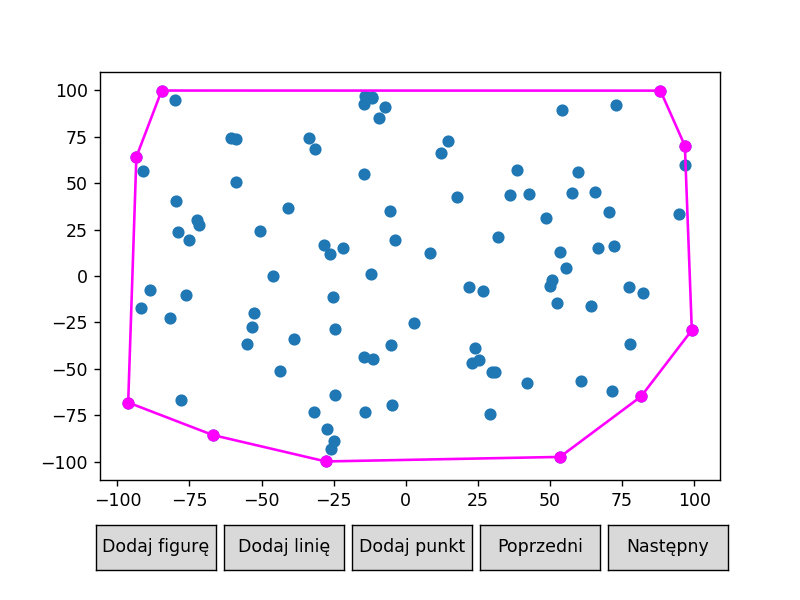

In [21]:
convex_hull_1_jarvis = jarvis_algorithm(data_set_1.tolist(), save_results=True, filename="convex_hull_1_jarvis.txt")
plot = Plot(scenes=convex_hull_1_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 2

<IPython.core.display.Javascript object>


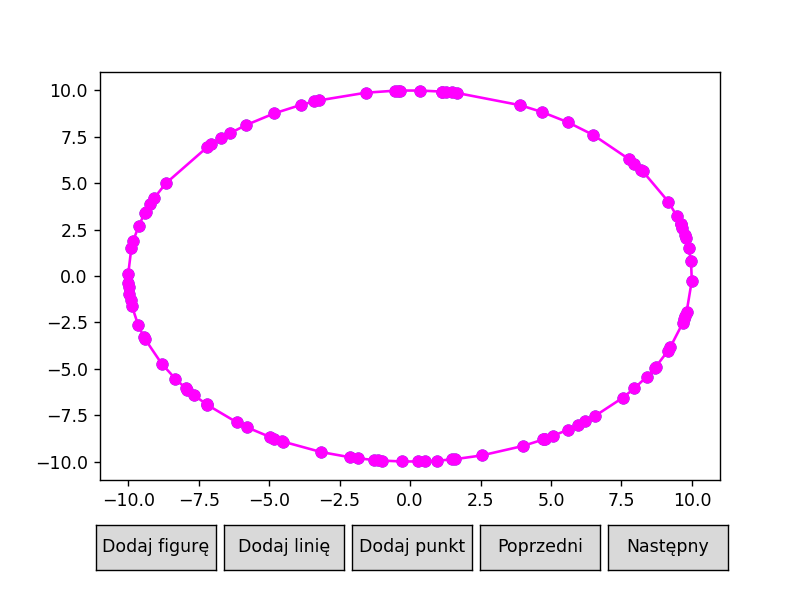

In [22]:
convex_hull_2_jarvis = jarvis_algorithm(data_set_2.tolist(), save_results=True, filename="convex_hull_2_jarvis.txt")
plot = Plot(scenes=convex_hull_2_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 3

<IPython.core.display.Javascript object>


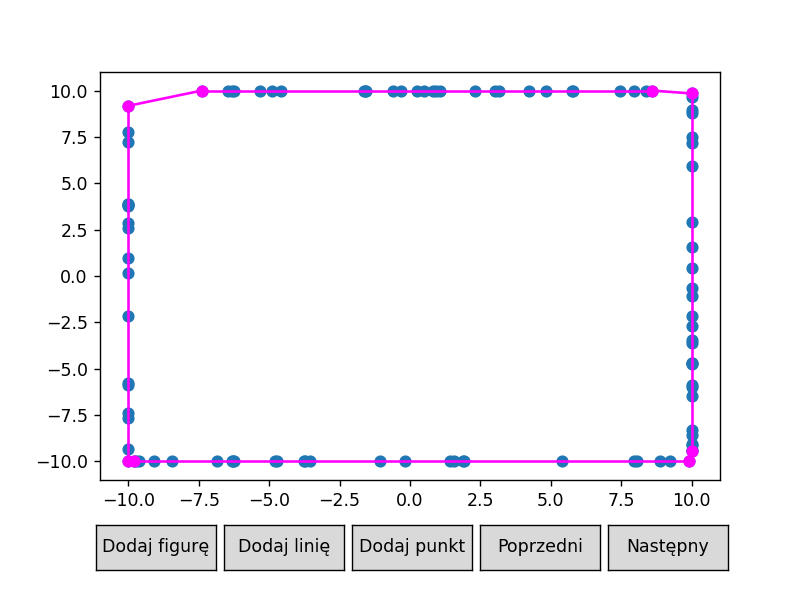

In [23]:
convex_hull_3_jarvis = jarvis_algorithm(data_set_3.tolist(), save_results=True, filename="convex_hull_3_jarvis.txt")
plot = Plot(scenes=convex_hull_3_jarvis)
plot.draw()

## Algorytm Jarvisa dla zbioru punktów nr 4

<IPython.core.display.Javascript object>


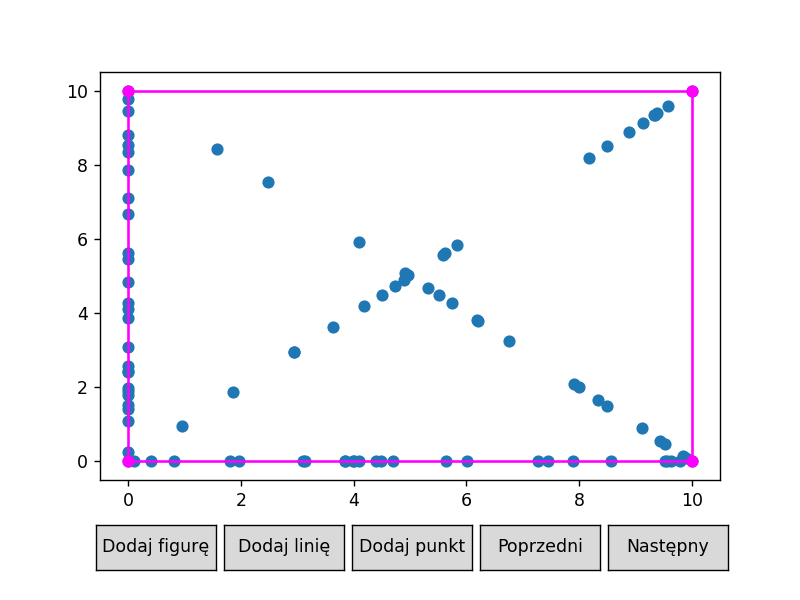

In [24]:
convex_hull_4_jarvis = jarvis_algorithm(data_set_4.tolist(), save_results=True, filename="convex_hull_4_jarvis.txt")
plot = Plot(scenes=convex_hull_4_jarvis)
plot.draw()

# Testy czasowe

In [25]:
from timeit import default_timer as timer
import pandas as pd
import seaborn as sns

In [26]:
def graham_algorithm_tst(data_set, tolerance=10e-12):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    sorted_data = sorted(data_set, key=compare(lambda x, y: angle_classification(min_pt, x, y, tolerance)))
    sorted_data, removed_data = remove_collinear(sorted_data, min_pt, tolerance)
    
    stack = []
    stack.extend(sorted_data[:3])
    idx = len(stack)
    
    while idx < len(sorted_data):
        pt_a, pt_b = stack[-2], stack[-1]
        pt_next = sorted_data[idx]
        
        if angle_orientation(pt_a, pt_b, pt_next) == -1:
            stack.append(pt_next)
            idx += 1
        else:
            stack.pop()
    
    if angle_orientation(pt_a, pt_b, min_pt) == 0:
        stack.pop()
        
    return stack

In [27]:
def jarvis_algorithm_tst(data_set, tolerance=10e-12):
    min_pt = min(data_set, key=lambda x: (x[1], x[0]))
    stack = []
    pt_stack = min_pt
    
    while True:
        stack.append(pt_stack)
        pt_last = data_set[0]
        
        for idx in range(len(data_set)):
            pt_last = min_angle(pt_stack, pt_last, data_set[idx])
        
        pt_stack = pt_last
        if pt_stack == min_pt:
            break
    
    return stack

In [28]:
def performance_test(set_generator, set_num, num_points):
    
    if set_num == 1:
        sets = list(map(lambda x: set_generator(x, (-100, 100)), num_points))
    elif set_num == 2:
        sets = list(map(lambda x: set_generator(x, (0, 0), 10), num_points))
    elif set_num == 3:
        sets = list(map(lambda x: set_generator(x, [(-10, 10), (-10, -10), (10, -10), (10, 10)]), num_points))
    elif set_num == 4:
        sets = list(map(lambda x: set_generator(x//4-1, x//4-1, [(0, 0), (0, 10), (10, 0), (10, 10)]), num_points))
        
    results = []
    names = ["Ilość punktów", "Czas algorytmu Grahama [sek]", "Czas algorytmu Jarvisa [sek]"]
    
    ind = 0
    for d_set in sets:
        set_len = len(d_set)
        
        start = timer()
        graham_algorithm_tst(d_set.tolist())
        end = timer()
        graham_time = round(end-start, 5)
        
        start = timer()
        jarvis_algorithm_tst(d_set.tolist())
        end = timer()
        jarvis_time = round(end-start, 5)

        results.append((set_len, graham_time, jarvis_time))
        
        ind += 1
        print(f"Test {ind} dla {set_len} punktów wykonany")
    
    return pd.DataFrame(data=results, columns=names)

In [29]:
def print_tests(results):
    return results.head().style.hide_index().set_properties(**{"text-align": "center"})

In [30]:
def draw_tests(results, set_num):
    plt.figure(figsize=(8,6))
    sns.regplot(data=results, x="Ilość punktów", y="Czas algorytmu Grahama [sek]", label="Algorytm Grahama")
    ax = sns.regplot(data=results, x="Ilość punktów", y="Czas algorytmu Jarvisa [sek]", label="Algorytm Jarvisa")
    ax.set(xlabel="Ilość punktów", ylabel="Czas [sek]")
    plt.legend(loc="upper left")
    plt.title(f"Porównanie czasów dla \nzbioru punktów nr {set_num}")

## Zbiór punktów nr 1

In [31]:
results_set_1 = performance_test(generate_set_1, 1, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_1)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Czas algorytmu Grahama [sek],Czas algorytmu Jarvisa [sek]
100,0.000880,0.001540
1000,0.012720,0.027370
5000,0.072830,0.146240
10000,0.158590,0.283410
20000,0.335960,0.760840


<IPython.core.display.Javascript object>


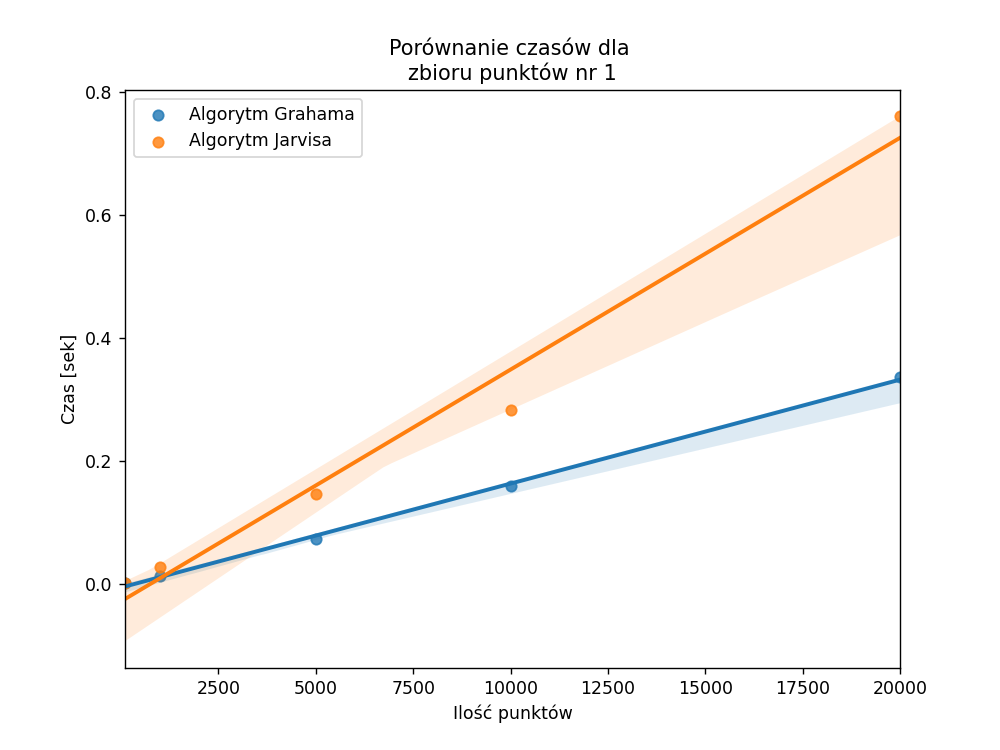

In [32]:
draw_tests(results_set_1, 1)

## Zbiór punktów nr 2

In [33]:
results_set_2 = performance_test(generate_set_2, 2, [100, 500, 1000, 1500, 2000])
print_tests(results_set_2)

Test 1 dla 100 punktów wykonany
Test 2 dla 500 punktów wykonany
Test 3 dla 1000 punktów wykonany
Test 4 dla 1500 punktów wykonany
Test 5 dla 2000 punktów wykonany


Ilość punktów,Czas algorytmu Grahama [sek],Czas algorytmu Jarvisa [sek]
100,0.001180,0.016720
500,0.005560,0.356150
1000,0.011150,1.406730
1500,0.017070,3.205490
2000,0.022760,5.678550


<IPython.core.display.Javascript object>


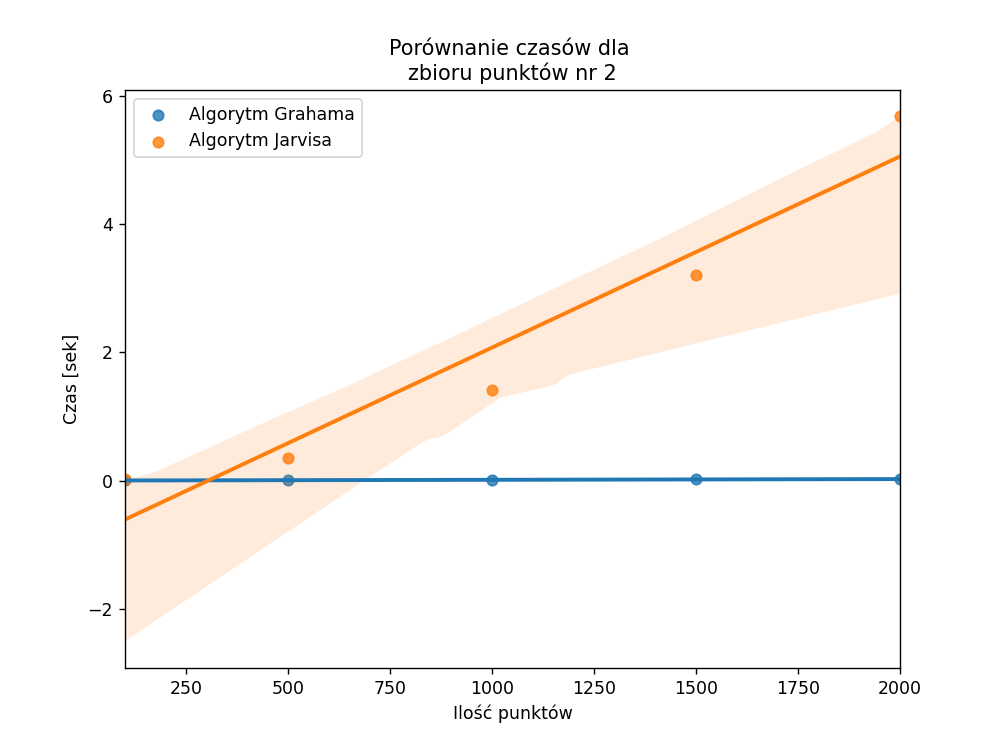

In [34]:
draw_tests(results_set_2, 2)

## Zbiór punktów nr 3

In [35]:
results_set_3 = performance_test(generate_set_3, 3, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_3)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Czas algorytmu Grahama [sek],Czas algorytmu Jarvisa [sek]
100,0.000980,0.002030
1000,0.013450,0.021270
5000,0.077320,0.101000
10000,0.161800,0.197570
20000,0.356360,0.398370


<IPython.core.display.Javascript object>


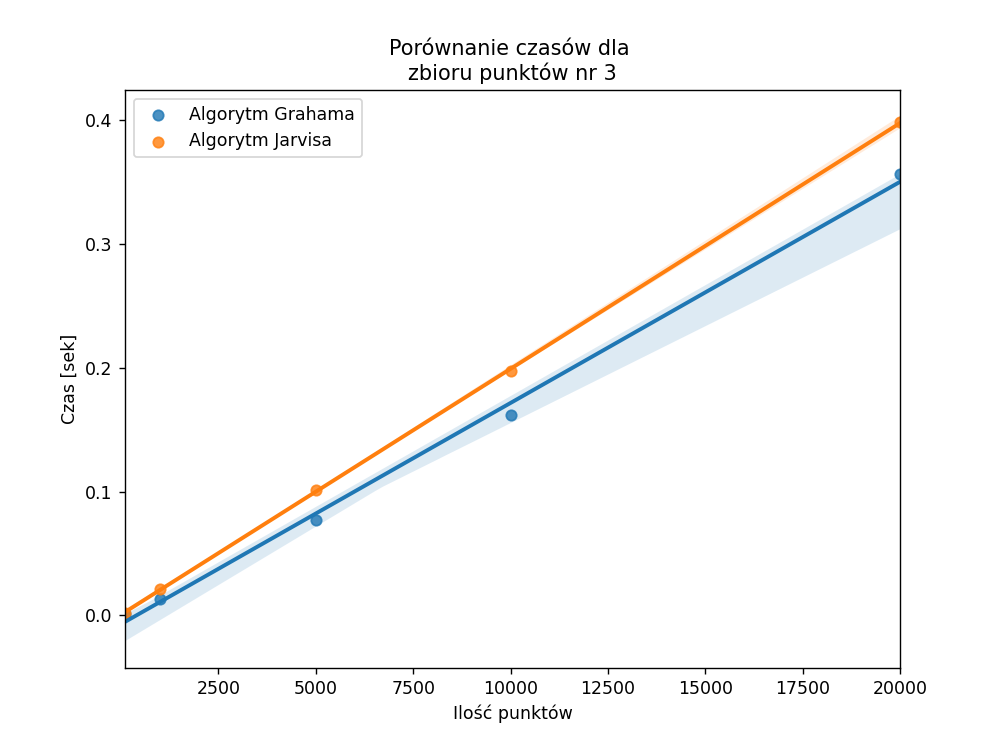

In [36]:
draw_tests(results_set_3, 3)

## Zbiór punktów nr 4

In [37]:
results_set_4 = performance_test(generate_set_4, 4, [100, 1000, 5000, 10000, 20000])
print_tests(results_set_4)

Test 1 dla 100 punktów wykonany
Test 2 dla 1000 punktów wykonany
Test 3 dla 5000 punktów wykonany
Test 4 dla 10000 punktów wykonany
Test 5 dla 20000 punktów wykonany


Ilość punktów,Czas algorytmu Grahama [sek],Czas algorytmu Jarvisa [sek]
100,0.001170,0.001240
1000,0.010540,0.012970
5000,0.056410,0.060880
10000,0.125070,0.131070
20000,0.261700,0.243600


<IPython.core.display.Javascript object>


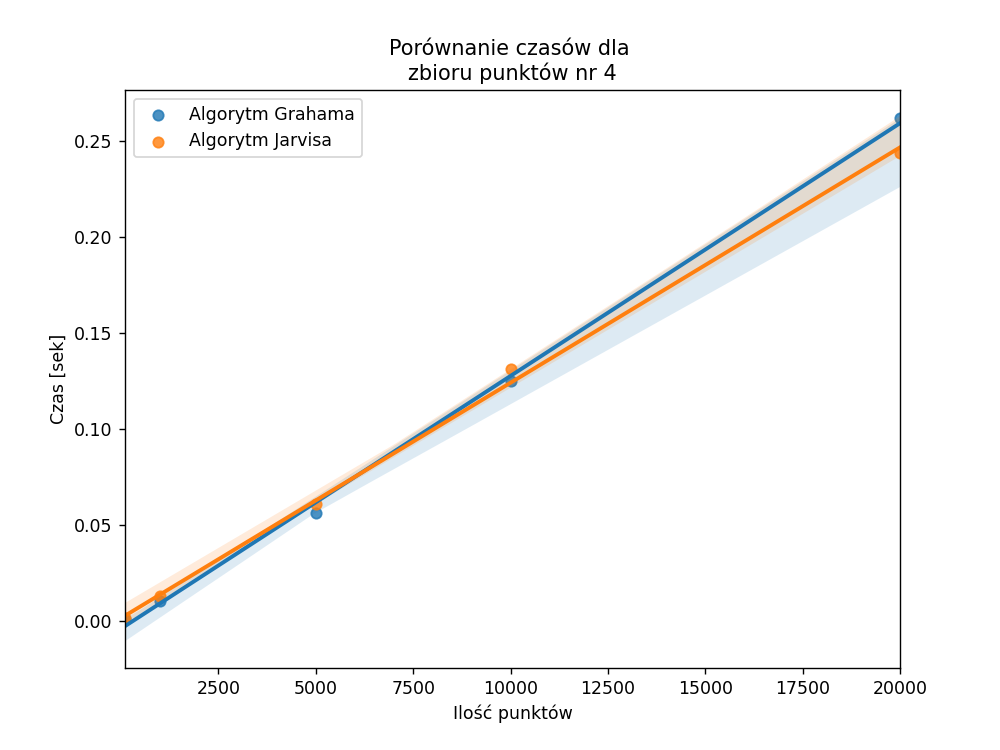

In [38]:
draw_tests(results_set_4, 4)